In [5]:
import cv2

from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle

print("all libraries loaded successfully.")
print(f"OpenCV version: {cv2.__version__}")

all libraries loaded successfully.
OpenCV version: 4.11.0


In [6]:
# --- config ----
from enum import Enum
import os
import cv2
import numpy as np
from typing import List, Tuple, Dict, Optional
from sklearn.model_selection import train_test_split

class Config:
    """Configuration class"""
    DATA_DIR = "Dataset/iCubWorld1/" # Dataset directory
    IMAGE_SIZE = (256, 256)     # image size
    VOCAB_SIZE = 400 # visual vocabulary size(K value)
    RANDOM_STATE = 42 # random state for reproducibility
    IMAGE_EXT = '.ppm' # image extension
    MAX_CORNERS = 200 # Harris
    HARRIS_MIN_DISTANCE = 4 # Harris
    HARRIS_QUALITY_LEVEL = 0.01 # Harris
    HARRIS_THRESH = 1e-4     # Harris
    DETECTOR_TYPE = 'HARRIS_SIFT'  #  SIFT，‘ORB’，‘HARRIS_SIFT’，‘HARRIS_AFFINE’
    FEATURE_LIMIT_PER_IMAGE = 100 #
    VOCAB_SAMPLE_LIMIT = 6000 #

    # Harris parameters
    AFFINE_MAX_ITERATIONS = 20
    AFFINE_RESPONSE_THRESHOLD = 0.01
    AFFINE_EDGE_THRESHOLD = 10
    INIT_KEYPOINT_SIZE = 20

class BaseDataLoader:
    """basedata loader"""
    def __init__(self, data_dir: str = Config.DATA_DIR):
        self.data_dir = data_dir
        # check the dir
        if not os.path.exists(self.data_dir):
             raise FileNotFoundError(f"don't find the dir: {self.data_dir}")
        train_dir = os.path.join(self.data_dir, "train")
        if not os.path.exists(train_dir):
             raise FileNotFoundError(f"Train dir didn't find: {train_dir}")
        self.classes = self._load_classes()

    def _load_classes(self) -> List[str]:
        train_dir = os.path.join(self.data_dir, "train")
        classes = []
        for name in os.listdir(train_dir):
            full = os.path.join(train_dir, name)
            if os.path.isdir(full):
                classes.append(name)
        return sorted(classes)

    def _collect_images(self, directory: str, is_test: bool = False) -> Tuple[List[str], List[int]]:
        paths, labels = [], []
        if not os.path.exists(directory):
            print(f"Warn: directory didn't exist: {directory}")
            return paths, labels

        class_name = ""
        if is_test:
            # `testset：test/modes/bananas/000000.ppm
             parts = directory.split(os.sep)
             if len(parts) >= 2:
                 class_name = parts[-1]
             else:
                 print(f"Warn: can't sure the categories name: {directory}")
                 return paths, labels

        else:
            # Trainset：train/bananas/bananas_1/000000.ppm

            parts = directory.split(os.sep)
            if len(parts) >= 2:
                 class_name = parts[-2]
            else:
                 print(f"Warn: can't sure the categories name{directory}")
                 return paths, labels


        try:
            class_idx = self.classes.index(class_name)
        except ValueError:

            print(f"Warn: Unknow class '{class_name}' in dir: {directory}")

            return paths, labels

        for fname in os.listdir(directory):
            if fname.endswith(Config.IMAGE_EXT):
                paths.append(os.path.join(directory, fname))
                labels.append(class_idx)

        return paths, labels

    def get_class_names(self) -> List[str]:
        return self.classes

class TrainDataLoader(BaseDataLoader):
    def __init__(self, data_dir: str = Config.DATA_DIR, max_samples_per_class: Optional[int] = None):
        super().__init__(data_dir)
        self.max_samples_per_class = max_samples_per_class

    def load_data(self) -> Tuple[List[str], List[int]]:
        all_paths, all_labels = [], []
        train_root = os.path.join(self.data_dir, "train")

        print("Start load the train data...")
        for idx, cls in enumerate(tqdm(self.classes, desc="categories")):
            cls_dir = os.path.join(train_root, cls)
            class_paths_collected = []
            class_labels_collected = []

            for instance in os.listdir(cls_dir):
                instance_dir = os.path.join(cls_dir, instance)
                if os.path.isdir(instance_dir):
                    paths, labels = self._collect_images(instance_dir, is_test=False)
                    class_paths_collected.extend(paths)
                    class_labels_collected.extend(labels)

            if self.max_samples_per_class is not None and len(class_paths_collected) > self.max_samples_per_class:
                indices = np.random.choice(len(class_paths_collected), self.max_samples_per_class, replace=False)
                sampled_paths = [class_paths_collected[i] for i in indices]
                sampled_labels = [class_labels_collected[i] for i in indices]
                all_paths.extend(sampled_paths)
                all_labels.extend(sampled_labels)
            else:
                all_paths.extend(class_paths_collected)
                all_labels.extend(class_labels_collected)

        print(f"Finished the load.... Total {len(all_paths)} images。")
        return all_paths, all_labels


class TestDataLoader(BaseDataLoader):
    """Load the test data"""
    def __init__(self, data_dir: str = Config.DATA_DIR, max_samples_per_class: Optional[int] = None):
        super().__init__(data_dir)
        self.max_samples_per_class = max_samples_per_class
        test_dir = os.path.join(data_dir, "test")
        if not os.path.exists(test_dir):
            raise ValueError(f"Test dir do not exist: {test_dir}")

        self.test_types = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
        if not self.test_types:
             print(f"Warn: Can't find the sub dir under {test_dir} ")
        else:
            print(f"find the test type: {self.test_types}")


    def load_data(self) -> Dict[str, Tuple[List[str], List[int]]]:
        """加载测试数据"""
        test_sets = {}
        test_root = os.path.join(self.data_dir, "test")

        print("Start load the test data...")
        for test_type in tqdm(self.test_types, desc="categories"):
            try:
                paths, labels = self._load_test_type(test_type)
                if paths:
                    test_sets[test_type] = (paths, labels)
                    self._print_test_set_stats(test_type, paths, labels)
                    if len(paths) != len(labels):
                         raise ValueError(f"path and labels do not match: {len(paths)} vs {len(labels)}")
                else:
                    print(f"Warn: Test type {test_type} didn't load any data")

            except Exception as e:
                print(f"erro in load {test_type} : {str(e)}")
                test_sets[test_type] = ([], [])

        print("Finished the loading of data")
        return test_sets

    def _load_test_type(self, test_type: str) -> Tuple[List[str], List[int]]:
        paths, labels = [], []
        test_type_dir = os.path.join(self.data_dir, "test", test_type)

        for cls in self.classes:
            cls_dir = os.path.join(test_type_dir, cls)

            if not os.path.exists(cls_dir):
                continue

            cls_paths, cls_labels = self._collect_images(cls_dir, is_test=True)

            if cls_paths:
                if self.max_samples_per_class is not None:
                    cls_paths, cls_labels = self._sample_data(cls_paths, cls_labels)

                paths.extend(cls_paths)
                labels.extend(cls_labels)

        return paths, labels

    def _sample_data(self, paths: List[str], labels: List[int]) -> Tuple[List[str], List[int]]:
        sample_size = min(len(paths), self.max_samples_per_class)
        if sample_size == 0:
             return [], []
        indices = np.random.choice(len(paths), sample_size, replace=False)
        return [paths[i] for i in indices], [labels[i] for i in indices]

    def _print_test_set_stats(self, test_type: str, paths: List[str], labels: List[int]) -> None:
        """print"""
        if not paths:
            return
        print(f"\n--- Testset: {test_type} ---")
        print(f"Total sample: {len(paths)}")


        unique_labels, counts = np.unique(labels, return_counts=True)
        label_counts = dict(zip(unique_labels, counts))

        for idx, cls in enumerate(self.classes):
            count = label_counts.get(idx, 0)
            percentage = (count / len(labels) * 100) if labels else 0
            print(f"  categories {cls}: {count} sample ({percentage:.1f}%)")
        print("-" * (len(f"--- testset: {test_type} ---")))

print("Finished the load of testloader")

Finished the load of testloader


find the test type: ['background', 'categorization', 'demonstrator', 'robot']
Start load the train data...


categories: 100%|██████████| 10/10 [00:00<00:00, 205.10it/s]


Finished the load.... Total 6002 images。
Start load the test data...


categories:   0%|          | 0/4 [00:00<?, ?it/s]


--- Testset: background ---
Total sample: 100
  categories bananas: 10 sample (10.0%)
  categories bottles: 10 sample (10.0%)
  categories boxes: 10 sample (10.0%)
  categories bread: 10 sample (10.0%)
  categories cans: 10 sample (10.0%)
  categories lemons: 10 sample (10.0%)
  categories pears: 10 sample (10.0%)
  categories peppers: 10 sample (10.0%)
  categories potatoes: 10 sample (10.0%)
  categories yogurt: 10 sample (10.0%)
---------------------------

--- Testset: categorization ---
Total sample: 2001
  categories bananas: 200 sample (10.0%)
  categories bottles: 200 sample (10.0%)
  categories boxes: 200 sample (10.0%)
  categories bread: 200 sample (10.0%)
  categories cans: 200 sample (10.0%)
  categories lemons: 200 sample (10.0%)
  categories pears: 200 sample (10.0%)
  categories peppers: 200 sample (10.0%)
  categories potatoes: 200 sample (10.0%)
  categories yogurt: 201 sample (10.0%)
-------------------------------


categories: 100%|██████████| 4/4 [00:00<00:00, 85.62it/s]


--- Testset: demonstrator ---
Total sample: 2001
  categories bananas: 200 sample (10.0%)
  categories bottles: 200 sample (10.0%)
  categories boxes: 200 sample (10.0%)
  categories bread: 200 sample (10.0%)
  categories cans: 200 sample (10.0%)
  categories lemons: 200 sample (10.0%)
  categories pears: 201 sample (10.0%)
  categories peppers: 200 sample (10.0%)
  categories potatoes: 200 sample (10.0%)
  categories yogurt: 200 sample (10.0%)
-----------------------------

--- Testset: robot ---
Total sample: 802
  categories bananas: 64 sample (8.0%)
  categories bottles: 76 sample (9.5%)
  categories boxes: 76 sample (9.5%)
  categories bread: 83 sample (10.3%)
  categories cans: 75 sample (9.4%)
  categories lemons: 83 sample (10.3%)
  categories pears: 76 sample (9.5%)
  categories peppers: 69 sample (8.6%)
  categories potatoes: 70 sample (8.7%)
  categories yogurt: 130 sample (16.2%)
----------------------
Finished the loading of data

 loded the data: 
 - Training smaples: 60

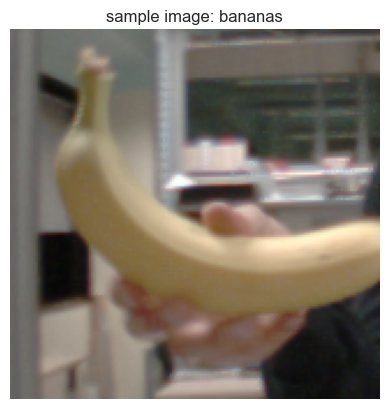

In [7]:

from tqdm import tqdm

# random seed
np.random.seed(Config.RANDOM_STATE)


train_loader = TrainDataLoader(data_dir=Config.DATA_DIR)
test_loader = TestDataLoader(data_dir=Config.DATA_DIR)

# load the data
train_paths, train_labels = train_loader.load_data()
test_sets = test_loader.load_data()

class_names = train_loader.get_class_names()

print(f"\n loded the data: ")
print(f" - Training smaples: {len(train_paths)}")
print(f" - Number of class: {len(class_names)}")
print(f" - class name: {class_names}")
print(f" - test mode: {list(test_sets.keys())}")

# 检查是否有测试数据被加载
if not test_sets:
    print("\n warning: there is no test data loaded, please check the TestDataLoader logic and test data directory structure.")
else:
    for test_type, (paths, _) in test_sets.items():
        print(f" - Testset '{test_type}' sample: {len(paths)}")


if train_paths:
    img_example = cv2.imread(train_paths[0])
    if img_example is not None:
        plt.imshow(cv2.cvtColor(img_example, cv2.COLOR_BGR2RGB))
        plt.title(f"sample image: {class_names[train_labels[0]]}")
        plt.axis('off')
        plt.show()
    else:
        print(f"Can't load the image: {train_paths[0]}")
else:
    print("there is no training data loaded, please check the TrainDataLoader logic and test data directory structure.")

In [8]:

def extract_sift_features(image_path: str, feature_limit: Optional[int] = None) -> Optional[np.ndarray]:

    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: can't load image: {image_path}")
            return None 

        if len(img.shape) == 2 or (len(img.shape) == 3 and img.shape[2] == 1):
            gray = img
        elif len(img.shape) == 3 and img.shape[2] == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        elif len(img.shape) == 3 and img.shape[2] == 4:
            gray = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
        else:
            print(f"Warning: Image {image_path}can not identify the path: {img.shape}. Skip this image。")
            return None 


        sift = cv2.SIFT_create()

        keypoints = []
        descriptors = None

        if Config.DETECTOR_TYPE == 'SIFT':
            sift = cv2.SIFT_create(nfeatures=getattr(Config, 'FEATURE_LIMIT_PER_IMAGE', 0))
            keypoints, descriptors = sift.detectAndCompute(gray, None)

        elif Config.DETECTOR_TYPE == 'ORB':
            orb = cv2.ORB_create(nfeatures=getattr(Config, 'FEATURE_LIMIT_PER_IMAGE', 500))
            keypoints, descriptors = orb.detectAndCompute(gray, None)

        elif Config.DETECTOR_TYPE == 'HARRIS_SIFT':
            
            corners = cv2.goodFeaturesToTrack(
                gray,
                maxCorners=Config.MAX_CORNERS,
                qualityLevel=Config.HARRIS_QUALITY_LEVEL,
                minDistance=Config.HARRIS_MIN_DISTANCE,
            )

            if corners is not None and len(corners) > 0:
                keypoints = [
                    cv2.KeyPoint(
                        float(pt[0][0]),  # x
                        float(pt[0][1]),  # y
                        20                # size
                    )
                    for pt in corners
                ] 


                sift_descriptor_extractor = cv2.SIFT_create()

                keypoints, descriptors = sift_descriptor_extractor.compute(gray, keypoints)

            else:
                keypoints = []
                descriptors = np.array([]) 

        elif Config.DETECTOR_TYPE == 'HARRIS_AFFINE':
                corners = cv2.goodFeaturesToTrack(
                    gray,
                    maxCorners=Config.MAX_CORNERS,
                    qualityLevel=Config.HARRIS_QUALITY_LEVEL,
                    minDistance=Config.HARRIS_MIN_DISTANCE
                )
                if corners is None or len(corners) == 0:
                    return None

                init_kps = [
                    cv2.KeyPoint(float(c[0][0]), float(c[0][1]), Config.INIT_KEYPOINT_SIZE)
                    for c in corners
                ]

                sift_base = cv2.xfeatures2d.SIFT_create()
                affine_detector = cv2.xfeatures2d.AffineAdaptedFeatureDetector_create(
                    sift_base,
                    maxIterations=Config.AFFINE_MAX_ITERATIONS,
                    responseThreshold=Config.AFFINE_RESPONSE_THRESHOLD,
                    edgeThreshold=Config.AFFINE_EDGE_THRESHOLD
                )

                affine_kps = affine_detector.detect(gray, init_kps)

                keypoints, descriptors = sift_base.compute(gray, affine_kps)

        else:
            raise ValueError(f"Unknown DETECTOR_TYPE: {Config.DETECTOR_TYPE}")

            keypoints, descriptors = sift.detectAndCompute(img, None)



            if descriptors is None or len(descriptors) == 0:
                print(f"`info: Can't find SIFT descriptors in image {os.path.basename(image_path)} .")
                return None

            if feature_limit is not None and len(keypoints) > feature_limit:
                indices = np.argsort([kp.response for kp in keypoints])[::-1][:feature_limit]
                descriptors = descriptors[indices]
                # keypoints = [keypoints[i] for i in indices] 

        return descriptors.astype(np.float32) 

    except Exception as e:
        print(f"Error: Wrong when process the image {image_path} : {e}")
        return None

if train_paths:
    print("extracting features from the first training image...")
    example_descriptors = extract_sift_features(train_paths[0], feature_limit=Config.FEATURE_LIMIT_PER_IMAGE)
    if example_descriptors is not None:
        print(f"sample image extract  {example_descriptors[0]} descriptors, then the dimension is {example_descriptors.shape[1]}")
    else:
        print("fail to extract the features, please check the image path and the image format.")
else:
    print("no training data, skip the feature extraction test.")

extracting features from the first training image...
sample image extract  [  3.  12.  83.   4.   2.   4.  37.   6.   6.  11.  70.  23.  14.   9.
  46.   7.   3.   3.  12.   7.   7.   4.   8.   2.   0.   0.   0.   0.
   0.   0.   0.   0.  19.  24.  78.  10.  33.  64. 135.  34.  29.  24.
  81.  38.  52.  63. 135.  61.   6.   3.   7.  18.  31.  26.  19.   7.
   0.   0.   0.   0.   0.   0.   0.   0.  36.  57. 135.  24.  20.  72.
 135.  59.   8.  23. 135.  86.  58.  58. 135.  64.   1.   3.  21.  38.
  31.  23.  59.   4.   0.   0.   0.   0.   0.   0.   0.   0.   5.  28.
 135.  28.   4.  13.  64.  19.   1.   8. 135.  83.   3.   6.  85.  19.
   0.   3.  40.  20.   1.   3.  17.   1.   0.   0.   0.   0.   0.   0.
   0.   0.] descriptors, then the dimension is 128


In [9]:
# --- Visual Vocabulary Construction---

def build_vocabulary(image_paths: List[str], vocab_size: int, sample_limit: Optional[int] = None) -> Optional[
    MiniBatchKMeans]:
    all_descriptors = []
    print(f"Start extracting features to build vocabulary...")

    paths_to_process = image_paths
    if sample_limit is not None and len(image_paths) > sample_limit:
        print(f"Randomly sampling {sample_limit} images from {len(image_paths)} images to build vocabulary...")
        paths_to_process = np.random.choice(image_paths, sample_limit, replace=False).tolist()

    for image_path in tqdm(paths_to_process, desc="Extracting vocabulary features"):
        descriptors = extract_sift_features(image_path, feature_limit=Config.FEATURE_LIMIT_PER_IMAGE)
        if descriptors is not None:
            all_descriptors.append(descriptors)

    if not all_descriptors:
        print("Error: Could not extract features from any images to build vocabulary.")
        return None

    stacked_descriptors = np.vstack(all_descriptors)
    print(f"Extracted {stacked_descriptors.shape[0]} descriptors to build vocabulary.")

    if stacked_descriptors.shape[0] < vocab_size:
        print(
            f"Warning: Number of descriptors ({stacked_descriptors.shape[0]}) is less than vocabulary size ({vocab_size}). Reducing vocabulary size to {stacked_descriptors.shape[0]}.")
        vocab_size = stacked_descriptors.shape[0]
        if vocab_size == 0:
            print("Error: Number of descriptors is 0, cannot perform clustering.")
            return None

    print(f"Starting MiniBatchKMeans to build visual vocabulary of size {vocab_size}...")
    kmeans = MiniBatchKMeans(n_clusters=vocab_size,
                             random_state=Config.RANDOM_STATE,
                             batch_size=256 * 8,  # adjustable parameter
                             init='k-means++',  # initialization method
                             max_iter=100,  # adjustable parameter
                             n_init=10,  # explicitly set n_init
                             verbose=1)  # can set to 1 to see progress

    kmeans.fit(stacked_descriptors)
    print("Visual vocabulary construction complete.")

    return kmeans


vocabulary_kmeans = build_vocabulary(train_paths, Config.VOCAB_SIZE, sample_limit=Config.VOCAB_SAMPLE_LIMIT)

if vocabulary_kmeans:
    vocab_filename = f"visual_vocabulary_k{Config.VOCAB_SIZE}.pkl"
    with open(vocab_filename, 'wb') as f:
        pickle.dump(vocabulary_kmeans, f)
    print(f"Visual vocabulary saved to {vocab_filename}")
else:
    print("Failed to build visual vocabulary. Following steps cannot proceed.")


Start extracting features to build vocabulary...
Randomly sampling 6000 images from 6002 images to build vocabulary...


Extracting vocabulary features: 100%|██████████| 6000/6000 [00:58<00:00, 103.20it/s]


Extracted 1169755 descriptors to build vocabulary.
Starting MiniBatchKMeans to build visual vocabulary of size 400...
Init 1/10 with method k-means++
Inertia for init 1/10: 417170912.0
Init 2/10 with method k-means++
Inertia for init 2/10: 419466496.0
Init 3/10 with method k-means++
Inertia for init 3/10: 415142016.0
Init 4/10 with method k-means++
Inertia for init 4/10: 414568256.0
Init 5/10 with method k-means++
Inertia for init 5/10: 415960640.0
Init 6/10 with method k-means++
Inertia for init 6/10: 417314464.0
Init 7/10 with method k-means++
Inertia for init 7/10: 415612416.0
Init 8/10 with method k-means++
Inertia for init 8/10: 419536896.0
Init 9/10 with method k-means++
Inertia for init 9/10: 417103232.0
Init 10/10 with method k-means++
Inertia for init 10/10: 417958976.0
[MiniBatchKMeans] Reassigning 21 cluster centers.
Minibatch step 1/57116: mean batch inertia: 67036.25
Minibatch step 2/57116: mean batch inertia: 54653.0234375, ewa inertia: 54653.0234375
Minibatch step 3/5711

In [11]:
# --- Image Representation (Bag-of-Words Histogram) ---

def compute_bow_histogram(descriptors: Optional[np.ndarray], kmeans_model: MiniBatchKMeans) -> np.ndarray:

    vocab_size = kmeans_model.n_clusters
    histogram = np.zeros(vocab_size, dtype=np.float32)

    if descriptors is not None and descriptors.shape[0] > 0:
        # Find the nearest visual word (cluster center) for each descriptor
        visual_words = kmeans_model.predict(descriptors)

        # Calculate frequencies of visual words
        unique_words, counts = np.unique(visual_words, return_counts=True)
        histogram[unique_words] = counts

        # L2 normalization (optional but recommended)
        # norm = np.linalg.norm(histogram)
        # if norm > 0:
        #     histogram /= norm

    # L1 normalization (another option)
    # total_features = np.sum(histogram)
    # if total_features > 0:
    #     histogram /= total_features

    return histogram


# Computing BoW features for all training data
if vocabulary_kmeans:
    print("\nComputing BoW features for training data...")
    X_train_bow = []
    y_train = []  # List of corresponding labels

    for i in tqdm(range(len(train_paths)), desc="Computing training set BoW"):
        path = train_paths[i]
        label = train_labels[i]

        descriptors = extract_sift_features(path, feature_limit=Config.FEATURE_LIMIT_PER_IMAGE)
        bow_hist = compute_bow_histogram(descriptors, vocabulary_kmeans)

        X_train_bow.append(bow_hist)
        y_train.append(label)  # Keep labels
    X_train_bow = np.array(X_train_bow)
    n_images, n_clusters = X_train_bow.shape
    df = np.count_nonzero(X_train_bow > 0, axis=0)
    doc_freq = df / n_images
    mask = (doc_freq >= 0.001) & (doc_freq <= 0.95)
    hist_filtered = X_train_bow[:, mask]
    from sklearn.feature_extraction.text import TfidfTransformer

    tfidf = TfidfTransformer(norm='l2')
    hist_tfidf = tfidf.fit_transform(hist_filtered).toarray()
    X_train_bow = hist_filtered

    y_train = np.array(y_train)
    print(f"Training set BoW features completed. Feature matrix shape: {X_train_bow.shape}")

    # Computing BoW features for all test data
    X_test_bow_sets = {}
    y_test_sets = {}
    print("\nComputing BoW features for test data...")
    for test_type, (paths, labels) in test_sets.items():
        print(f"Computing test set '{test_type}' BoW features...")
        X_test_bow = []
        y_test = []
        for i in tqdm(range(len(paths)), desc=f"Computing {test_type} BoW"):
            path = paths[i]
            label = labels[i]
            descriptors = extract_sift_features(path, feature_limit=Config.FEATURE_LIMIT_PER_IMAGE)
            bow_hist = compute_bow_histogram(descriptors, vocabulary_kmeans)
            X_test_bow.append(bow_hist)
            y_test.append(label)

        X_test_bow_sets[test_type] = np.array(X_test_bow)
        y_test_sets[test_type] = np.array(y_test)
        print(
            f"Test set '{test_type}' BoW features completed. Feature matrix shape: {X_test_bow_sets[test_type].shape}")

else:
    print("Error: No visual vocabulary available, cannot compute BoW features.")
    X_train_bow, y_train = None, None
    X_test_bow_sets, y_test_sets = {}, {}



Computing BoW features for training data...


Computing training set BoW: 100%|██████████| 6002/6002 [01:10<00:00, 85.43it/s] 


Training set BoW features completed. Feature matrix shape: (6002, 400)

Computing BoW features for test data...
Computing test set 'background' BoW features...


Computing background BoW: 100%|██████████| 100/100 [00:01<00:00, 82.76it/s]


Test set 'background' BoW features completed. Feature matrix shape: (100, 400)
Computing test set 'categorization' BoW features...


Computing categorization BoW: 100%|██████████| 2001/2001 [00:22<00:00, 89.84it/s] 


Test set 'categorization' BoW features completed. Feature matrix shape: (2001, 400)
Computing test set 'demonstrator' BoW features...


Computing demonstrator BoW: 100%|██████████| 2001/2001 [00:21<00:00, 94.85it/s] 


Test set 'demonstrator' BoW features completed. Feature matrix shape: (2001, 400)
Computing test set 'robot' BoW features...


Computing robot BoW: 100%|██████████| 802/802 [00:14<00:00, 56.70it/s]

Test set 'robot' BoW features completed. Feature matrix shape: (802, 400)


In [12]:
# --- Classifier Training and Recognition ---


if X_train_bow is not None and y_train is not None and X_train_bow.shape[0] > 0:
    print("\nStarting classifier training...")

    classifier = SVC(kernel='rbf', C=1.0, probability=False, random_state=Config.RANDOM_STATE)

    classifier.fit(X_train_bow, y_train)
    print("Classifier training completed.")

    classifier_filename = f"bow_classifier_{type(classifier).__name__}_k{Config.VOCAB_SIZE}.pkl"
    with open(classifier_filename, 'wb') as f:
        pickle.dump(classifier, f)
    print(f"Classifier saved to {classifier_filename}")

    print("\nEvaluating model performance on test sets...")
    if not X_test_bow_sets:
        print("No test set BoW features available for evaluation.")
    else:
        for test_type in test_sets.keys():
            print(f"\n--- Evaluating test set: {test_type} ---")
            if test_type not in X_test_bow_sets or X_test_bow_sets[test_type].shape[0] == 0:
                print(f"Skipping evaluation since test set '{test_type}' has no BoW features.")
                continue

            X_test = X_test_bow_sets[test_type]
            X_test_filt = X_test[:, mask]
            X_test_tfidf = tfidf.transform(X_test_filt).toarray()
            y_test = y_test_sets[test_type]

            # Make predictions
            y_pred = classifier.predict(X_test_filt)


            accuracy = accuracy_score(y_test, y_pred)
            print(f"Accuracy: {accuracy:.4f}")


            unique_test_labels = np.unique(y_test)
            current_target_names = [class_names[i] for i in unique_test_labels]

            report = classification_report(y_test, y_pred, labels=unique_test_labels, target_names=current_target_names,
                                           zero_division=0)
            print("Classification Report:")
            print(report)

else:
    print("Error: No training data (BoW features) available, cannot train or evaluate classifier.")



print("\n=== Pipeline Execution Complete ===")



Starting classifier training...
Classifier training completed.
Classifier saved to bow_classifier_SVC_k400.pkl

Evaluating model performance on test sets...

--- Evaluating test set: background ---
Accuracy: 0.9700
Classification Report:
              precision    recall  f1-score   support

     bananas       1.00      1.00      1.00        10
     bottles       1.00      0.70      0.82        10
       boxes       0.83      1.00      0.91        10
       bread       1.00      1.00      1.00        10
        cans       0.91      1.00      0.95        10
      lemons       1.00      1.00      1.00        10
       pears       1.00      1.00      1.00        10
     peppers       1.00      1.00      1.00        10
    potatoes       1.00      1.00      1.00        10
      yogurt       1.00      1.00      1.00        10

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100


-